In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## sys_micrograd

In [75]:
class Value:
    
    def __init__(self, data, _children=(), _op=(), label=''):
        self.data  = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Operations
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value( self.data + other.data , (self, other), '+') 
        
        def _backward(): # by addition our job is to propogate __add__'s out's grad into self and other 
                         # i.e pass it backward (the out.grad backwards to the 2 parents) other and self
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self): 
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other): # self/other
        return self * other**-1
        
    def __rmul__(self, other): # for the case of -- other * self
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value( self.data * other.data, (self, other), '*' ) 
          
        def _backward(): # by multiplication our job is to multiply the weight of the other variable (if we are talking about self we need other, if its other we need self)
                            # and we multiply this (ther other variables data) by the out.grad
                            # this is 
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward    
    
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "We only support int or float data types for now"
        out = Value( self.data ** other, (self,), f'**{other}' ) 
        
        def _backward(): 
            self.grad += (other * ( self.data ** (other-1)) )* out.grad # other = n, and self.data = n
        out._backward = _backward
        
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out
           
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        
        def _backward(): # this is simply the derivative of the tanh function, multiplied by the out.grad 
                            # since this is the chain rule 
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        # only adds a node once that nodes the children are added to the list
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        topo
        self.grad = 1.0
        # now we call the 
        for node in reversed(topo):
            node._backward()
    


In [76]:
a = Value(2.0)
b = Value(4.0)
a - b
# a/b is the same as  a * (1/b) or a * (b**-1)

Value(data=-2.0)

In [77]:
# helper fucntions to visualize everything happening behind the scenes

from graphviz import Digraph

# Step 1 - build the connections/tree of operations and operands
def trace(root):
    # This builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    # function to build everything
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    
    # now use this to build the trace fro, the root
    build(root)
    return nodes, edges

# Step 2 - Draw the connections/tree of operations and operands
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR - for left to right
    
    nodes, edges = trace(root)
    for _n in nodes:
        uid = str(id(_n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{ %s |  data %.4f | grad %.4f }" % (_n.label, _n.data, _n.grad ), shape='record')
        
        if _n._op:
            # a - if this value is a result of some operation, create an op node for it
            dot.node(name = uid + _n._op , label = _n._op)
            # b - and connec this node to it
            dot.edge(uid + _n._op, uid)
            
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge( str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [78]:
# PART 3 - Backpropagation on a neuron

In [79]:
# inputs of the network : x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the network : w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88137335870195432, label='b')

x1w1 = x1*w1 ; x1w1.label = "x1*w1";
x2w2 = x2*w2 ;  x2w2.label = "x2*w2";
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n' # neuron before activation function

o = n.tanh()
o.label = 'o'
o.backward()

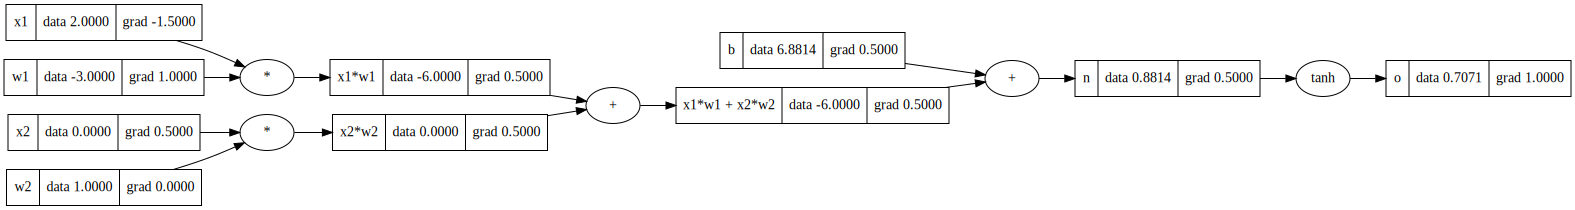

In [80]:
draw_dot(o)

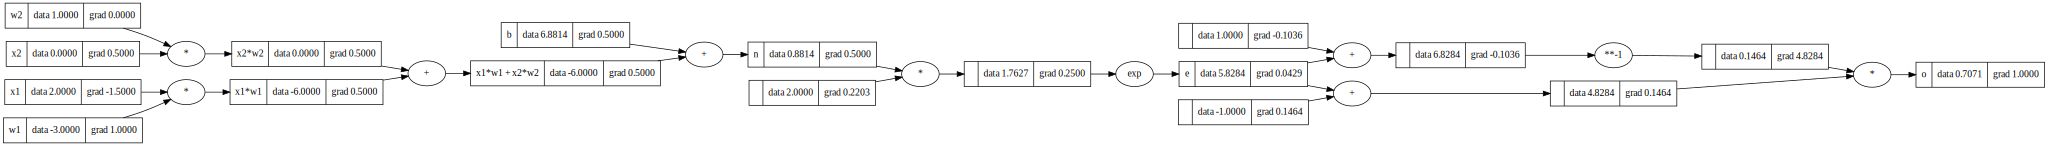

In [83]:
# inputs of the network : x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the network : w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88137335870195432, label='b')

x1w1 = x1*w1 ; x1w1.label = "x1*w1";
x2w2 = x2*w2 ;  x2w2.label = "x2*w2";
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n' # neuron before activation function

#-----------
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'
#-----------
o.label = 'o'
o.backward()
draw_dot(o)

In [97]:
import torch

# Tensors are n-dimensional arrays of scalars

x1 = torch.Tensor([2.0]).double() ;                   x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;                   x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ;                  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;                   w2.requires_grad = True

b = torch.Tensor([6.88137335870195432]).double() ;    b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o)
print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [94]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).double().dtype

torch.float64

In [98]:
o.item()

0.7071066904050358

In [101]:
x2.grad


tensor([0.5000], dtype=torch.float64)

In [103]:
import random

In [138]:

class Neuron:
    
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x ):
        # w * x + b
        #print(list(zip(self.w, x)))
        act =  sum( (wi*xi for wi, xi in zip(self.w, x)), self.b )
        out = act.tanh()
        return out
    
    
class Layer:
    
    def __init__(self, num_input, num_output):
        self.neurons = [Neuron(num_input) for _ in range(num_output)] # this creates a num_input* numoutput matric where each num_input == neruron
    
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))

print("starting layers")
m = Layer(2, 3)
m(x)

Value(data=-0.732193084432426)
starting layers


[Value(data=-0.7160823327356279),
 Value(data=-0.7359190476150295),
 Value(data=0.9259496176918398)]

In [152]:
class MLP: # Multi layer perceptron
    
    def __init__(self, num_inputs, num_outputs):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0] # 3d input
n = MLP(3, [4,4,1]) # 3 inputs to 2 layers of 3, with one output 
n(x)

Value(data=-0.8231080335055985)

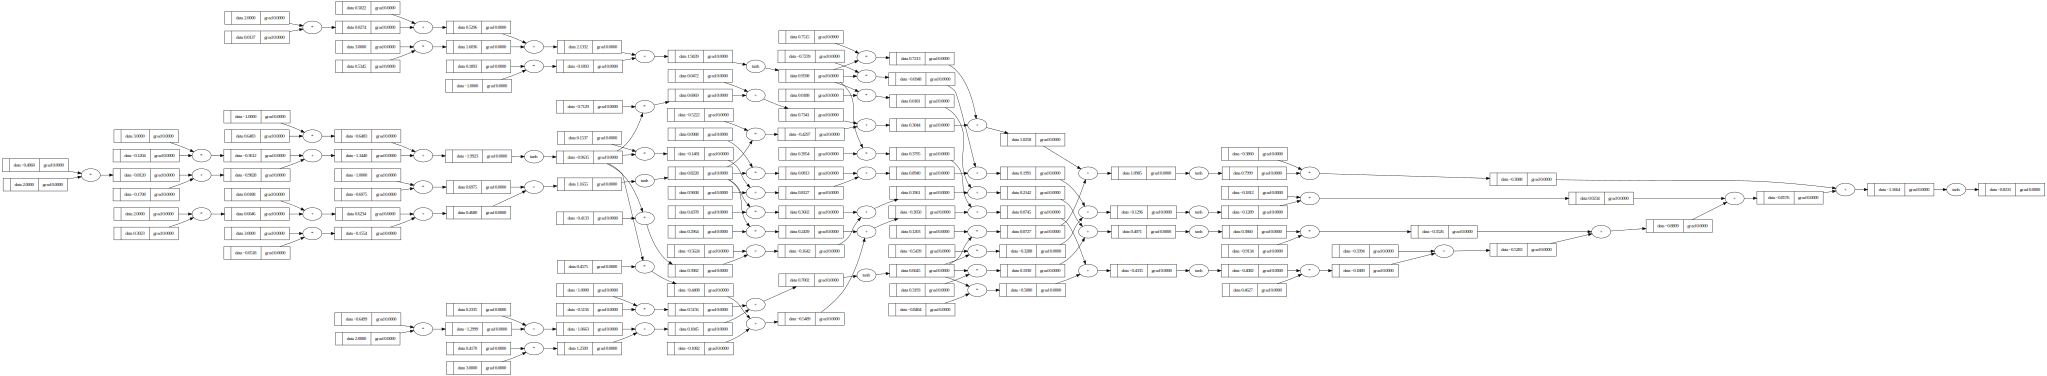

In [153]:
draw_dot(n(x))

In [154]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

ypred = [ n(x) for x in xs ]
ypred

[Value(data=-0.8231080335055985),
 Value(data=-0.05787429228476352),
 Value(data=0.11399799209331772),
 Value(data=-0.7896537197468957)]

In [155]:
print([(y_pred - y_ground_truth)**2 for y_ground_truth, y_pred in zip(ys,ypred)])

loss = sum( (y_pred - y_ground_truth)**2 for y_ground_truth, y_pred in zip(ys,ypred) ) # mean_squared_error
loss

[Value(data=3.3237229018326504), Value(data=0.8876008491379352), Value(data=1.2409915263879434), Value(data=3.202860436603901)]


Value(data=8.655175713962429)

In [156]:
loss.backward()

In [157]:
n.layers[0].neurons[0].w[0].grad

2.159313188345894

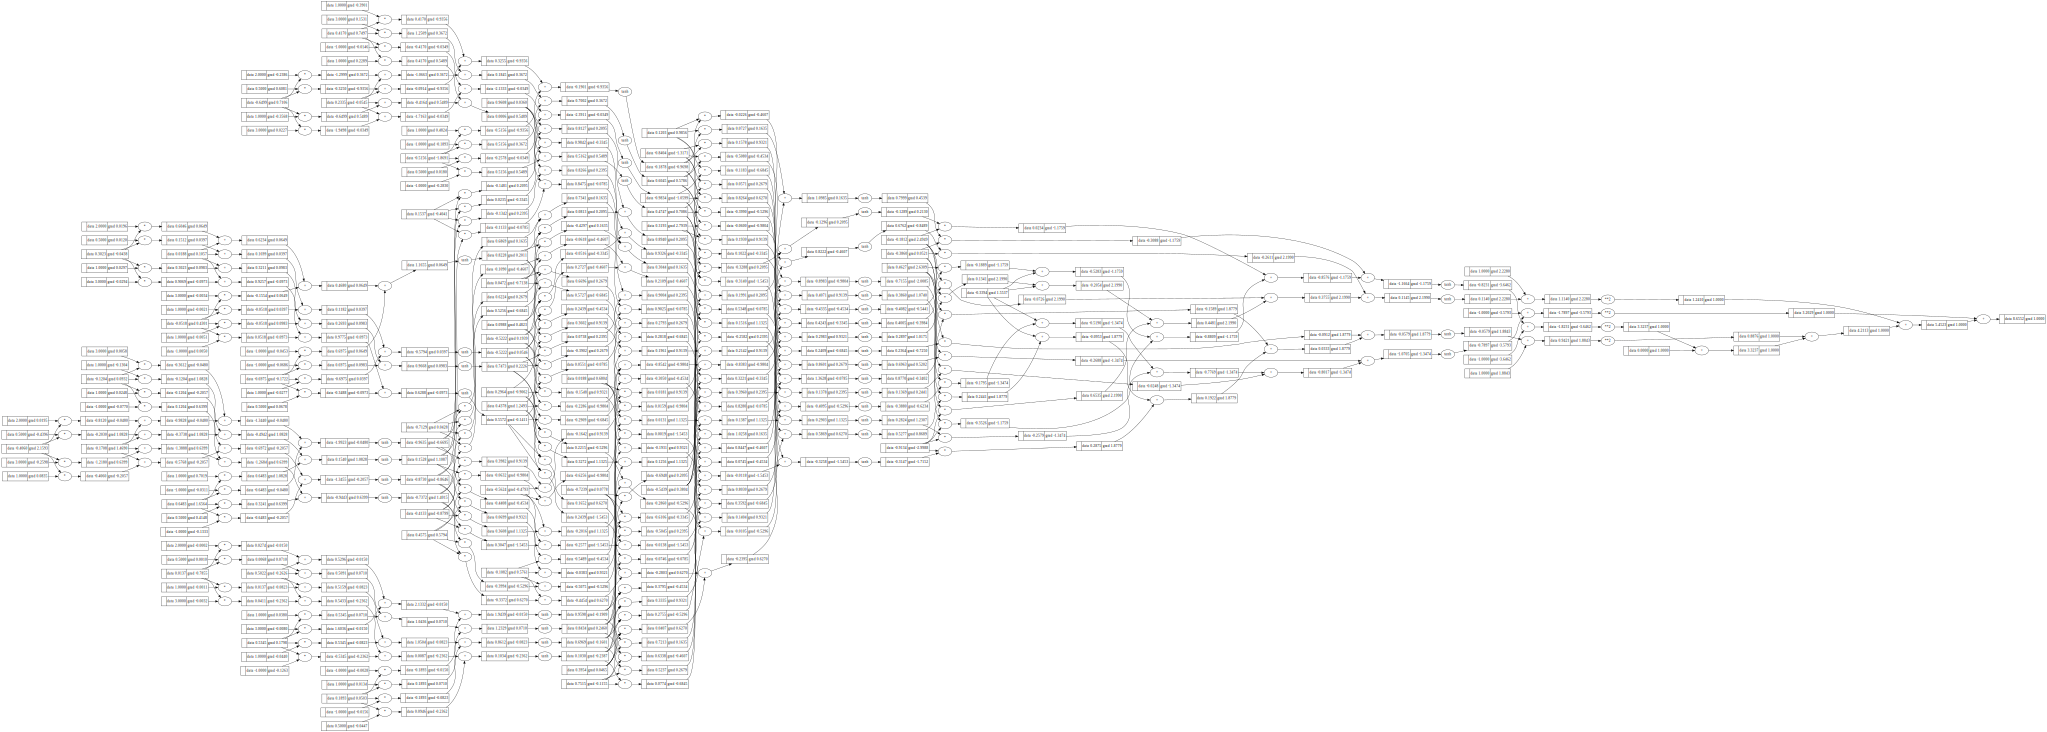

In [158]:
draw_dot(loss)